In [1]:
%%capture
#@title Install dependencies { display-mode: "form" }
!pip install numpy pandas matplotlib 
!pip install gensim spacy --upgrade

In [2]:
%%capture
#@title Clone our repository that contains the data { display-mode: "form" }
!git clone https://github.com/millawell/textexplorationen-in-der-digitalen-literaturwissenschaft
%cd textexplorationen-in-der-digitalen-literaturwissenschaft/code/

In [3]:
%%capture
#@title import dependencies and load data { display-mode: "form" }
DEBUG = True #@param {type:"boolean"}

import pandas as pd
import numpy as np
from bisect import bisect_left
from tqdm import tqdm
# from scripts import utils
import json
import itertools
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

from functools import partial
from pathlib import Path

from spacy.lang.de import German
nlp = German()
nlp.add_pipe("sentencizer")
tokenizer = nlp.tokenizer

preprocessed_data_fn = Path("processed_data") / "eltec.jsonl"

w2vs = {}
vocab = {}
embedding_matrix = {}

def iter_docs(in_path):
    with open(in_path, "r") as in_file:
        for iline, line in tqdm(enumerate(in_file), desc="load documents"):
            data = json.loads(line)
            yield data
            if iline > 10 and DEBUG:
                break
                
for doc in iter_docs(preprocessed_data_fn):
    if len(doc['text']) >= nlp.max_length:
        nlp.max_length = len(doc['text'])+1

def iter_sents(docs):
    for doc in docs:
        text = doc['text']
        for isent, sent in tqdm(enumerate(nlp(text).sents), desc="load sentences"):
            sentence = []
            for token in sent:
                sentence.append(token.text)
            yield {
                'text': sentence,
                'sentence_id': isent,
                **{k:v for k,v in doc.items() if k!='text'}
            }
            if isent > 100 and DEBUG:
                break
                
def iter_gender(iterable, gender='f'):
    if gender not in ['m', 'f']:
        raise ValueError('gender must be either "m" or "f", atm no other genders in the data :/')
    for it in iterable:
        if it['gender-cat']==gender:
             yield it
                
def iter_author(iterable, author='Willkomm, Ernst Adolf'):
    for it in iterable:
        if it['author-name']==author:
             yield it
                
for doc in iter_docs(preprocessed_data_fn):
    if len(doc['text']) >= nlp.max_length:
        nlp.max_length = len(doc['text'])+1

In [4]:
%%capture
#@title utils { display-mode: "form" }

def index_sorted_list(a, x):
    'Locate the leftmost value exactly equal to x'
    i = bisect_left(a, x)
    if i != len(a) and a[i] == x:
        return i
    raise ValueError


def lookup_embeddings(text, vocab, embedding_matrix):
    'For a given list of words, create embedding matrix'
    embeddings = np.zeros([len(text), embedding_matrix.shape[1]])

    for iword, word in enumerate(text):
        for token in tokenizer(str(word)):
            try:
                embeddings[iword] = embedding_matrix[index_sorted_list(vocab, word)]
            except ValueError:
                pass

    return embeddings


def word_attribute_association(w, A, B, vocab, embedding_matrix):
    # s(w,A,B) = mean_a cos(w,a) - mean_b cos(w,b)
    A_embed = lookup_embeddings(A, vocab, embedding_matrix)
    B_embed = lookup_embeddings(B, vocab, embedding_matrix)
    w_embed = lookup_embeddings(w, vocab, embedding_matrix)

    wA = np.dot(w_embed / np.linalg.norm(w_embed, axis=1)[:, np.newaxis],
                (A_embed / np.linalg.norm(A_embed, axis=1)[:, np.newaxis]).T).sum()
    wB = np.dot(w_embed / np.linalg.norm(w_embed, axis=1)[:, np.newaxis],
                (B_embed / np.linalg.norm(B_embed, axis=1)[:, np.newaxis]).T).sum()

    return wA / len(A) - wB / len(B)


def test_statistic(A, B, X, Y, vocab, embedding_matrix):
    wA = 0

    for ix in X:
        wA += word_attribute_association([ix], A, B, vocab, embedding_matrix)

    wB = 0

    for iy in Y:
        wB -= word_attribute_association([iy], A, B, vocab, embedding_matrix)

    return wA + wB


def calculate_pvalue(A, B, X, Y, vocab, embedding_matrix, alpha=0.05):
    # check out-of-vocab words
    A = list(set(A).intersection(vocab))
    B = list(set(B).intersection(vocab))
    X = list(set(X).intersection(vocab))
    Y = list(set(Y).intersection(vocab))

    test_stat_orig = test_statistic(A, B, X, Y, vocab, embedding_matrix)

    union = set(X + Y)
    subset_size = len(union) // 2

    larger = 0
    total = 0

    for subset in tqdm(set(itertools.combinations(union, subset_size))):
        total += 1
        Xi = list(set(subset))
        Yi = list(union - set(subset))
        if test_statistic(A, B, Xi, Yi, vocab, embedding_matrix) > test_stat_orig:
            larger += 1
    if larger / float(total) < alpha:
        print(
            "The difference between the attributes {} and {} \nfor the given target words is significant.".format(A, B))
    else:
        print(
            "The difference between the attributes {} and {} \nfor the given target words is not significant.".format(A,
                                                                                                                      B))

    return larger / float(total)

In [5]:
%%capture
#@title helper functions for w2v { display-mode: "form" }
class W2VDataset:
    def __init__(self, generator_factory):
        self.generator_factory = generator_factory
        self.length = None
 
    def __iter__(self):
        generator = self.generator_factory()
        i=0
        for i, it in enumerate(generator):
            yield it['text']
            
        self.length = i+1
            
    def __len__(self):
        if self.length is not None:
            return self.length
        
        self.length = len([_ for _ in self])
        return self.length
        

def train_w2v(vector_size=50, window=5, min_count=2, max_vocab_size=20000, epochs=2, split='gender', attribute='f'):
    
    if split=='gender':
        w2vdataset = W2VDataset(
            partial(
                iter_sents,
                (iter_gender(iter_docs(preprocessed_data_fn), gender=attribute))
            )
        )
        
    elif split=='author':
        
        authors = pd.DataFrame(iter_sents(iter_docs(preprocessed_data_fn)))['author-name'].unique()
        if attribute not in authors:
            raise ValueError('author not in list, check spelling: last name: first name1, first name2')
        
        w2vdataset = W2VDataset(
            partial(
                iter_sents,
                (iter_author(iter_docs(preprocessed_data_fn), author=attribute))
            )
        )
       
    else:
        w2vdataset = W2VDataset(
            partial(
                iter_sents, 
                iter_docs(preprocessed_data_fn)
            )
        )
    
    model = Word2Vec(
        sentences=w2vdataset,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        max_vocab_size=max_vocab_size,
        workers=4
    )
    
    model.train(
        w2vdataset,
        total_examples=len(w2vdataset),
        epochs=epochs
    )

    wv = model.wv

    vocab = wv.index_to_key
    vocab = sorted(vocab)

    vecs = [wv[it] for it in vocab]

    return pd.DataFrame(data=vecs, index=vocab)

def iter_embed_w2v(vecs, docs):
    for doc in docs:
        doc_representation = []
        for itoken, token in enumerate(doc['text']):
            try:
                doc_representation.append(vecs.loc[token])
            except KeyError:
                pass # some tokens are not embedded
        yield np.vstack(doc_representation).mean(axis=0)
        
        
def compute_tsne(words, vocab, embedding_matrix):
    return words, TSNE(
        n_components=2, 
        learning_rate='auto',
        init='random').fit_transform(lookup_embeddings(words,
                                                       vocab,
                                                       embedding_matrix))

def plot_tsne(words, tsne_rep):
    plt.scatter(tsne_rep[:,0], tsne_rep[:,1])
    for iword, word in enumerate(words):
        plt.annotate(word, tsne_rep[iword])
        

def nearest_neighbors(target, vocab, embedding_matrix, n=25, printout=True):
    target_emb = lookup_embeddings([target], vocab, embedding_matrix)
    sim_matrix = np.dot(target_emb/np.linalg.norm(target_emb), 
                        embedding_matrix.T/np.linalg.norm(embedding_matrix, axis=1)[:, None].T)

    nearest = [vocab[ii] for ii in np.flip(np.argsort(sim_matrix), axis=1)[0,:n]]
    if printout:
        print(nearest)
            
    return nearest

In [6]:
%%capture
#@title This cell trains word2vec embeddings on the whole corpus. You can also train embeddings on a split of the cropus, for example male and female authors choose split:gender and attribute:f,m { display-mode: "form" }

vector_size=20 #@param {type:"number"}
window=5 #@param {type:"number"}
min_count=2 #@param {type:"number"}
max_vocab_size=20000 #@param {type:"number"}
epochs=2 #@param {type:"number"}
split='gender' #@param ["all", "gender", "author", "book"]
attribute='m' #@param {type:"string"}

w2vs[attribute] = train_w2v(
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    max_vocab_size=max_vocab_size,
    epochs=epochs,
    split=split,
    attribute=attribute
)

vocab[attribute] = w2vs[attribute].index
embedding_matrix[attribute] = w2vs[attribute].values

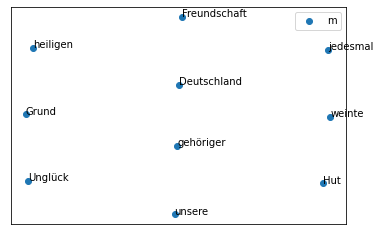

In [7]:
#@title This cell plots a 2-dimension TSNE embeddings of the closest word you choose as a target word. If you try different splits, it will show nearest neighbors for all splits in different colors. { display-mode: "form" }
target_word = "Deutschland" #@param {type:"string"}

for attribute in w2vs.keys():
    
    if target_word not in vocab[attribute]:
        raise ValueError(f"{target_word} not in vocab, please choose different word")

    nearest = nearest_neighbors(target_word, vocab[attribute], embedding_matrix[attribute], n=10, printout=False)
    words, tsne_rep = compute_tsne(nearest, vocab[attribute], embedding_matrix[attribute])
    plot_tsne(words, tsne_rep)

plt.xticks([])
plt.yticks([])
plt.legend(w2vs.keys())

In [8]:
%%capture
#@title This cell calculates the WEAT test between two attributes: A and B and a list of target words X and Y. We use a one-sided test, therefore it is not symmetric. The target words you assume are more associated with A should be in X and respectively the target words for B should be in Y

if 'all' not in w2vs:
    w2vs['all'] = train_w2v(
      vector_size=50,
      window=5,
      min_count=5,
      max_vocab_size=20000,
      epochs=2,
      split='all'
    )

    vocab['all'] = w2vs['all'].index
    embedding_matrix['all'] = w2vs['all'].values


#choose your attributes in A and B
A = ['weiblich', 'Frau']
B = ['männlich', 'Mann']

#choose your target words in X and Y
X = ['Hochzeit','Familie','Kind','Eltern','Ehe','Liebe']
Y = ['Krieg', 'Macht', 'Stärke', 'Mut', 'Wald', 'Kampf']

In [9]:
#@title Results WEAT 
p = calculate_pvalue(A,B,X,Y, vocab['all'], embedding_matrix['all'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 682.23it/s]

The difference between the attributes ['Frau'] and ['Mann'] 
for the given target words is not significant.
